Instructions (will analyze anyone's letterboxd data!)
- Within Letterboxd app, navigate to Settings -> data -> export as csv
- This notebook takes in the diary.csv file that is automatically generated -- just unpack the zip file
- I was only interested in looking at movies I had watched from 2023 onwards, so I filtered early dates out. Adjust for a different timeframe!
- Since color palette analysis is being conducted, need to use API key in order to access each movie poster

In [ ]:
from dotenv import load_dotenv
import ones
load_dotenv()

API_KEY = os.getenv("TMDB_API_KEY")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import pandas as pd
df=pd.read_csv('gdrive/MyDrive/diary.csv')

In [7]:
print(df)

           Date                                 Name    Year  \
0    2024-07-03                          Spare Parts  2020.0   
1    2024-06-24                    Princess Mononoke  1997.0   
2    2023-07-25  Spider-Man: Across the Spider-Verse  2023.0   
3    2023-07-25                                 Tusk  2014.0   
4    2023-07-25                                 Nope  2022.0   
..          ...                                  ...     ...   
157  2025-09-14                             Conclave  2024.0   
158  2025-09-15                        The Long Walk  2025.0   
159  2025-09-29                         Honey Don't!  2025.0   
160  2025-10-12                       Helter Skelter  2012.0   
161  2025-10-24                         Frankenstein  2025.0   

             Letterboxd URI  Rating Rewatch  \
0    https://boxd.it/6NgCeB     1.0     NaN   
1    https://boxd.it/6JKGA1     5.0     NaN   
2    https://boxd.it/4zYcj7     5.0     NaN   
3    https://boxd.it/4zYweV     2.5     NaN

In [8]:
pd.to_datetime(df['Watched Date']) # converting to datetime type so can remove earlier entries!

,Watched Date
0,2021-02-25
1,2021-06-09
2,2023-07-24
3,2023-07-24
4,2023-07-24
...,...
157,2025-09-14
158,2025-09-14
159,2025-09-28
160,2025-10-11


In [9]:
cutoff_datetime = pd.to_datetime('2023-01-01') # removing early than 2023
df_filtered = df[pd.to_datetime(df['Watched Date']) > cutoff_datetime]
print(df_filtered)

           Date                                 Name    Year  \
2    2023-07-25  Spider-Man: Across the Spider-Verse  2023.0   
3    2023-07-25                                 Tusk  2014.0   
4    2023-07-25                                 Nope  2022.0   
5    2023-07-29                                    X  2022.0   
6    2023-08-04                           Talk to Me  2022.0   
..          ...                                  ...     ...   
157  2025-09-14                             Conclave  2024.0   
158  2025-09-15                        The Long Walk  2025.0   
159  2025-09-29                         Honey Don't!  2025.0   
160  2025-10-12                       Helter Skelter  2012.0   
161  2025-10-24                         Frankenstein  2025.0   

             Letterboxd URI  Rating Rewatch  \
2    https://boxd.it/4zYcj7     5.0     NaN   
3    https://boxd.it/4zYweV     2.5     NaN   
4    https://boxd.it/4zYV47     4.5     NaN   
5    https://boxd.it/4BqNTL     4.5     NaN

In [10]:
print(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 2 to 161
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            160 non-null    object 
 1   Name            160 non-null    object 
 2   Year            159 non-null    float64
 3   Letterboxd URI  160 non-null    object 
 4   Rating          152 non-null    float64
 5   Rewatch         17 non-null     object 
 6   Tags            152 non-null    object 
 7   Watched Date    160 non-null    object 
dtypes: float64(2), object(6)
memory usage: 11.2+ KB
None


In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [12]:
print(df_filtered['Rating'].value_counts())

Rating
4.0    34
3.0    26
4.5    21
5.0    19
2.0    19
2.5    15
3.5    12
0.5     3
1.0     2
1.5     1
Name: count, dtype: int64


Adding new columns that I will populate as I go through each movie and find info from each movie's API/metadata

In [13]:
df_new = df_filtered.copy()
df_new['Genre'] = None
df_new["Language"]=None
df_new["Runtime"]=None
df_new["Color Palette"]=None
print(df_new)

           Date                                 Name    Year  \
2    2023-07-25  Spider-Man: Across the Spider-Verse  2023.0   
3    2023-07-25                                 Tusk  2014.0   
4    2023-07-25                                 Nope  2022.0   
5    2023-07-29                                    X  2022.0   
6    2023-08-04                           Talk to Me  2022.0   
..          ...                                  ...     ...   
157  2025-09-14                             Conclave  2024.0   
158  2025-09-15                        The Long Walk  2025.0   
159  2025-09-29                         Honey Don't!  2025.0   
160  2025-10-12                       Helter Skelter  2012.0   
161  2025-10-24                         Frankenstein  2025.0   

             Letterboxd URI  Rating Rewatch  \
2    https://boxd.it/4zYcj7     5.0     NaN   
3    https://boxd.it/4zYweV     2.5     NaN   
4    https://boxd.it/4zYV47     4.5     NaN   
5    https://boxd.it/4BqNTL     4.5     NaN

There were one or two entries I couldn't find on TMDB w/my basic loop so I used Chat GPT to help find edge cases:
- it cleans the title first (gets rid of extra characters/normalizes etc.)
- within the loop, it also takes the year into account to make sure that it finds the correct film.
- this is important since some movies might have been published under multiple titles - this was the case with "Raw" (2016) which was originally titled "Grave"   
- finally, if title isn't found, searches the TV show database as well (e.g. "Over the Garden Wall" is under TV!)

Prints out if wasn't able to find movie. from my dataset, the only ones it couldn't find were the Black Mirror episodes, which makes sense because of their format. So, won't be taking them into account for color analysis

In [14]:
import requests, time, unicodedata

def clean_title(t):
    return unicodedata.normalize("NFKD", t).encode("ascii", "ignore").decode()
# cleaning the titles before making the request
for index, row in df_new.iterrows():
    title = clean_title(row['Name'])
    # below, making sure to take year into account when finding in database - helps prevent
    year = int(row.iloc[2]) if not pd.isna(row.iloc[2]) else None  # 3rd coln
    params = {
        "api_key": TMDB_API_KEY,
        "query": title,
        "include_adult": True
    }
    if year:
        params["year"] = year

    resp = requests.get("https://api.themoviedb.org/3/search/movie", params=params).json()

    # try looking for tv show results too if still isn't showing up
    if not resp["results"]:
        resp = requests.get("https://api.themoviedb.org/3/search/tv", params=params).json()

    if resp["results"]:
        movie_id = resp["results"][0]["id"]
        details = requests.get(
            f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={TMDB_API_KEY}"
        ).json()
        result = resp["results"][0]
        title_found = result.get("title") or result.get("name")
        poster_path = result.get("poster_path")

        # also, I want to store some other info for stats. info is: genre, runtime, original language
        df_new.at[index, "Genre"] = [g["id"] for g in details.get("genres", [])] # here, just stored as an ID -> before analysis, will have to translate ID to actual genre (get from TMDB)
        df_new.at[index, "Runtime"] = details.get("runtime")
        df_new.at[index, "Language"] = details.get("original_language")# same here, just an abbreviated version of language

        if poster_path:
          url = f"https://image.tmdb.org/t/p/w500{poster_path}"
          response = requests.get(url)
          img = Image.open(BytesIO(response.content)) # just loading img in from url
          palette = img.convert("P", palette=Image.ADAPTIVE, colors=3)
          palette_colors = palette.getpalette()[:3*3]  # top 3 RGB vals!

          df_new.at[index, "Color Palette"] = palette_colors
          # print("Poster URL:", f"https://image.tmdb.org/t/p/w500{poster_path}") #-> not printing out the path anymore

    # prints out any unsuccessful finds, just to be aware of what they are!
    else:
        print(f"NOT FOUND: {title}")

    time.sleep(0.25)


NOT FOUND: Black Mirror: Common People
NOT FOUND: Black Mirror: Plaything
NOT FOUND: Black Mirror: Arkangel
NOT FOUND: Black Mirror: Bete Noire
NOT FOUND: Black Mirror: Hated in the Nation
NOT FOUND: Black Mirror: Rachel, Jack and Ashley Too


In [15]:
# genre/language mappings access - define these
genre_map = {g["id"]: g["name"] for g in requests.get(
    f"https://api.themoviedb.org/3/genre/movie/list?api_key={TMDB_API_KEY}"
).json()["genres"]}

langs_resp = requests.get(
    f"https://api.themoviedb.org/3/configuration/languages?api_key={TMDB_API_KEY}"
).json()
lang_map = {l["iso_639_1"]: l["english_name"] for l in langs_resp}


# now create new colns with full genre (rather than just ID), non-abbreviated language
df_new["GenreNames"] = df_new["Genre"].apply(
    lambda ids: [genre_map.get(i, "Unknown") for i in ids] if isinstance(ids, list) else []
)
df_new["LanguageName"] = df_new["Language"].map(lang_map)

In [13]:
print(df_new)

           Date                                 Name    Year  \
3    2023-07-25  Spider-Man: Across the Spider-Verse  2023.0   
4    2023-07-25                                 Tusk  2014.0   
5    2023-07-25                                 Nope  2022.0   
6    2023-07-29                                    X  2022.0   
7    2023-08-04                           Talk to Me  2022.0   
..          ...                                  ...     ...   
158  2025-09-14                             Conclave  2024.0   
159  2025-09-15                        The Long Walk  2025.0   
160  2025-09-29                         Honey Don't!  2025.0   
161  2025-10-12                       Helter Skelter  2012.0   
162  2025-10-24                         Frankenstein  2025.0   

             Letterboxd URI  Rating Rewatch  \
3    https://boxd.it/4zYcj7     5.0     NaN   
4    https://boxd.it/4zYweV     2.5     NaN   
5    https://boxd.it/4zYV47     4.5     NaN   
6    https://boxd.it/4BqNTL     4.5     NaN

In [16]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# creating new df that drops any with missing palette entries
df_colors = df_new.dropna(subset=["Color Palette"]).copy()

# palette list -> 2D array
X = np.vstack(df_colors["Color Palette"].values)

# run K-Means clustering:
k = 7   # adjust based on how many clusters you want
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_colors["Palette Cluster"] = kmeans.fit_predict(X)

# print out how the head of df is classified
print(df_colors[["Name", "Color Palette", "Palette Cluster"]].head())


                                  Name  \
2  Spider-Man: Across the Spider-Verse   
3                                 Tusk   
4                                 Nope   
5                                    X   
6                           Talk to Me   

                              Color Palette  Palette Cluster  
2  [233, 169, 113, 156, 71, 87, 58, 14, 36]                6  
3    [200, 92, 87, 152, 35, 31, 49, 18, 15]                1  
4       [33, 68, 122, 9, 30, 61, 4, 11, 19]                4  
5    [158, 100, 79, 92, 43, 31, 30, 16, 13]                4  
6        [28, 35, 37, 8, 13, 16, 7, 12, 15]                4  


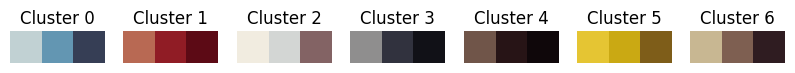

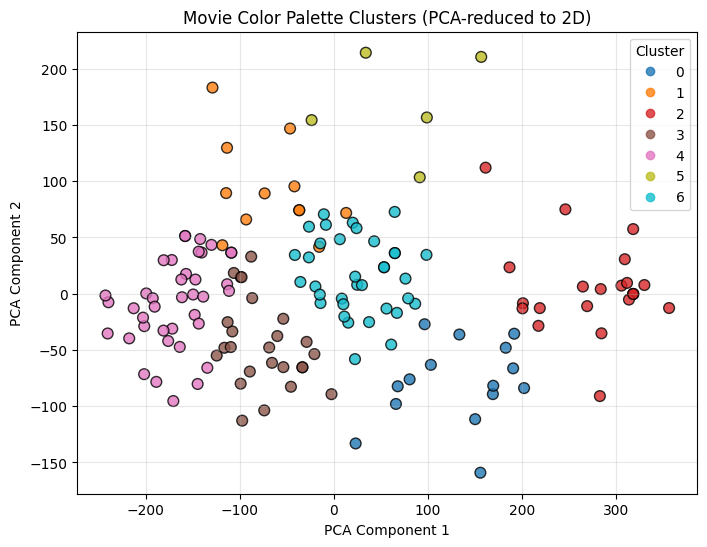

In [17]:
import matplotlib.pyplot as plt


#printing out centers of each cluster


cluster_centers = kmeans.cluster_centers_.reshape(k, 3, 3).astype(int)


plt.figure(figsize=(10, 2))
for i, cluster in enumerate(cluster_centers):
   plt.subplot(1, k, i+1)
   plt.imshow([cluster / 255])
   plt.axis("off")
   plt.title(f"Cluster {i}")
plt.show()
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


# pca dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_2D = pca.fit_transform(X)


# storing in DataFrame for easy plotting
df_colors["PCA1"] = X_2D[:, 0]
df_colors["PCA2"] = X_2D[:, 1]


# creating basic plot visualization in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
   df_colors["PCA1"],
   df_colors["PCA2"],
   c=df_colors["Palette Cluster"],
   cmap="tab10",
   s=60,
   alpha=0.8,
   edgecolors="k"
)
plt.title("Movie Color Palette Clusters (PCA-reduced to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True, alpha=0.3)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

## Now, collecting some summary statistics to report back to user:

In [18]:
avescore = df_new['Rating'].mean()
print(avescore)

3.460526315789474


In [19]:
genre_counts = (
    df_new["GenreNames"]
    .explode()             # turns each list element into its own row
    .dropna()
    .value_counts()       #  NOW do value counts

)

print(genre_counts)

top_genres=genre_counts.head(5).index.tolist()

GenreNames
Drama              61
Horror             53
Comedy             45
Thriller           42
Romance            31
Science Fiction    29
Adventure          22
Fantasy            21
Mystery            21
Action             16
Family             11
Animation          10
Crime               7
Music               7
TV Movie            3
History             2
Documentary         1
War                 1
Name: count, dtype: int64


In [20]:
df_new["Watched Date"] = pd.to_datetime(df_new["Watched Date"], errors="coerce")
df_new["Month"] = df_new["Watched Date"].dt.to_period("M")   # e.g. 2025-03
monthly_counts = df_new.groupby("Month").size()
monthly_avg = monthly_counts.mean()
print(monthly_avg)

6.956521739130435


In [21]:
# now doing the same thing with tags
all_tags = (
    df["Tags"]
    .dropna()
    .astype(str)
    .str.split(",")
    .sum()  # concatenates lists across all rows
)
all_tags = [t.strip() for t in all_tags]
pd.Series(all_tags).value_counts().head(10)

top_tags= pd.Series(all_tags).value_counts().head(5).index.tolist()

In [31]:
unique_languages = df_new["LanguageName"].dropna().unique().tolist()
unique_languages.remove('No Language') # here, removing the No Language Tag
print("Unique Languages:", unique_languages)

Unique Languages: ['English', 'French', 'Japanese', 'Irish', 'Mandarin', 'Cantonese', 'Korean', 'Norwegian', 'Italian']


In [32]:
runtime= df_new["Runtime"].dropna().sum() / 60
print(runtime)

274.2


In [34]:
summary_stats ={
    "Average Rating": avescore,
    "Top 5 Genres": top_genres,
    "Top 5 Tags": top_tags,
    "Languages Watched in": unique_languages,
    "Monthly Average": monthly_avg,
    "Total Movie Number": len(df_new),
    "Total Runtime (hrs)": runtime
}
pd.DataFrame([summary_stats]).to_csv("summary_stats.csv", index=False)

## Finally, exporting the following csv files:
- Summary stats
- diary_final (all info, removing some uneccessary columns from df_new)
- df_colors (has cluster classifications!)

In [25]:
diary_final = df_new.drop(['Rewatch', 'Genre', 'Language'], axis=1)
print(diary_final)

           Date                                 Name    Year  \
2    2023-07-25  Spider-Man: Across the Spider-Verse  2023.0   
3    2023-07-25                                 Tusk  2014.0   
4    2023-07-25                                 Nope  2022.0   
5    2023-07-29                                    X  2022.0   
6    2023-08-04                           Talk to Me  2022.0   
..          ...                                  ...     ...   
157  2025-09-14                             Conclave  2024.0   
158  2025-09-15                        The Long Walk  2025.0   
159  2025-09-29                         Honey Don't!  2025.0   
160  2025-10-12                       Helter Skelter  2012.0   
161  2025-10-24                         Frankenstein  2025.0   

             Letterboxd URI  Rating  \
2    https://boxd.it/4zYcj7     5.0   
3    https://boxd.it/4zYweV     2.5   
4    https://boxd.it/4zYV47     4.5   
5    https://boxd.it/4BqNTL     4.5   
6    https://boxd.it/4DG6NF     2.5 

In [26]:
diary_final.to_csv("diary_final.csv")
df_colors.to_csv("df_colors.csv")

In [35]:
from google.colab import files
files.download("summary_stats.csv")
files.download("diary_final.csv")
files.download("df_colors.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>